# Amazon Fine Food Reviews

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Hyperparameters

In [1]:
hyperparameters = {
    'limit': -1,
    'downsample_ratio': 0.25,
    'tfidf_num_features': 50000,
    'min_support': 5,
    'cv_vocab_size': 50000,
    'rf_num_trees': 20,
    'rf_max_categories': 10,
    'nb_smoothing': 0.1,
    'lr_iterations': 20, 
    'lr_regparam': 0.3,
    'lr_elastic': 0.8,
    'svm_maxIter': 20, 
    'svm_reg': 0.1
}

## Load Dataset

We first attempted to solve this as a multiclass classification problem (i.e. predict the score based on the review on a scale of 1 through 5, same as the dataset) but this proved to be too hard given the tools we were using and so we opted for an "easier" problem which is a binary classification of whether or not the review was a positive one or a negative one (0 or 1)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, HashingTF, IDF
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

df = spark.read.csv('Reviews.csv',header=False, schema=StructType([
    StructField('Id', IntegerType(), True),
    StructField('ProductId', StringType(), True),
    StructField('UserId', StringType(), True),
    StructField('ProfileName', StringType(), True),
    StructField('HelpfulnessNumerator', IntegerType(), True),
    StructField('HelpfulnessDenominator', IntegerType(), True),
    StructField('Score', IntegerType(), True),
    StructField('Time', IntegerType(), True),
    StructField('Summary', StringType(), True),
    StructField('Text', StringType(), True)]))
if hyperparameters['limit'] > 0:
    df = df.limit(hyperparameters['limit'])
df = df.filter('Id' > 0 and length('Text') > 0).filter(col('Score') > 0).filter(col('Score') != 3)
df = df.withColumn('label', (when(col('Score') > 3, 1.0).otherwise(0)))
df = df.select('Text', 'Summary', 'label')
print df.count(), 'reviews'
df.show()

524549 reviews
+--------------------+--------------------+-----+
|                Text|             Summary|label|
+--------------------+--------------------+-----+
|I have bought sev...|Good Quality Dog ...|  1.0|
|"Product arrived ...|   Not as Advertised|  0.0|
|"This is a confec...|"""Delight"" says...|  1.0|
|If you are lookin...|      Cough Medicine|  0.0|
|Great taffy at a ...|         Great taffy|  1.0|
|I got a wild hair...|          Nice Taffy|  1.0|
|This saltwater ta...|Great!  Just as g...|  1.0|
|This taffy is so ...|Wonderful, tasty ...|  1.0|
|Right now I'm mos...|          Yay Barley|  1.0|
|This is a very he...|    Healthy Dog Food|  1.0|
|I don't know if i...|The Best Hot Sauc...|  1.0|
|One of my boys ne...|"My cats LOVE thi...|  1.0|
|My cats have been...|My Cats Are Not F...|  0.0|
|good flavor! thes...|   fresh and greasy!|  1.0|
|The Strawberry Tw...|Strawberry Twizzl...|  1.0|
|My daughter loves...|Lots of twizzlers...|  1.0|
|I love eating the...|          poo

## Preprocess

In [3]:
regexTokenizer = RegexTokenizer(inputCol='Text', outputCol='Tokenized', pattern='\\W')
add_stopwords = ['amazon', 'br', 'is', 'a', 'this', 'i', 'if', 'for', 'gp',
                 'are', 'of', 'am', 'its', 'you', 'as', 'my', 'the', 'href'] 
stopwordsRemover = StopWordsRemover(inputCol='Tokenized', 
                                    outputCol='filtered').setStopWords(add_stopwords)
regexTokenizerSummary = RegexTokenizer(inputCol='Summary', 
                                       outputCol='SummaryTokenized', pattern='\\W')
stopwordsRemoverSummary = StopWordsRemover(inputCol='SummaryTokenized', 
                                           outputCol='filteredSummary').setStopWords(
    add_stopwords)
df = Pipeline(stages=[regexTokenizer, stopwordsRemover, regexTokenizerSummary, 
                      stopwordsRemoverSummary]).fit(df).transform(df)
df.show()

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                Text|             Summary|label|           Tokenized|            filtered|    SummaryTokenized|     filteredSummary|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|I have bought sev...|Good Quality Dog ...|  1.0|[i, have, bought,...|[have, bought, se...|[good, quality, d...|[good, quality, d...|
|"Product arrived ...|   Not as Advertised|  0.0|[product, arrived...|[product, arrived...|[not, as, adverti...|   [not, advertised]|
|"This is a confec...|"""Delight"" says...|  1.0|[this, is, a, con...|[confection, that...|[delight, says, i...|[delight, says, i...|
|If you are lookin...|      Cough Medicine|  0.0|[if, you, are, lo...|[looking, secret,...|   [cough, medicine]|   [cough, medicine]|
|Great taffy at a ...|         Great taffy|  1.0|[great, taffy

## Investigating the Data

We chose to use the Text and Summary alone since the amount of users who found the review helpful will not tell us about the nature of the review (i.e. positive or negative)

In [4]:
print 'min review length (in words)', df.select(min(size('Tokenized'))).collect()[0][0]
print 'max review length (in words)', df.select(max(size('Tokenized'))).collect()[0][0]
print 'average review length (in words)', df.select(mean(size('Tokenized'))).collect()[0][0]

min review length (in words) 1
max review length (in words) 2258
average review length (in words) 71.2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1209500d0>]],
      dtype=object)

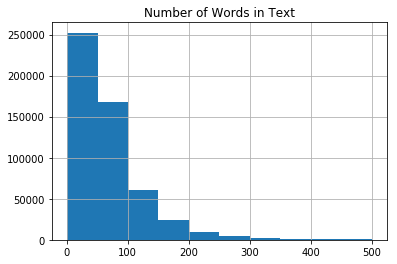

In [5]:
df.select(size('Tokenized').alias('Number of Words in Text')).toPandas().hist(range=[1, 500])

You can see that there are reviews with just one word and that there are reviews with a very high number of words but that for the most part most reviews are in the range of 50 words

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113b21210>]],
      dtype=object)

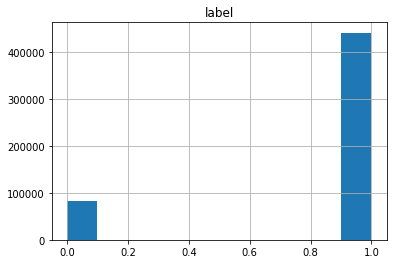

In [6]:
df.select('label').toPandas().hist(range=[0, 1])

You can see that we have a very unbalanced dataset, most of the reviews are positive

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113b67850>]],
      dtype=object)

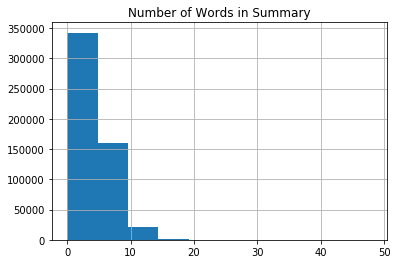

In [7]:
df.select(size('SummaryTokenized').alias('Number of Words in Summary')).toPandas().hist()

Examples for an ironic review and a mixed (positive AND negative) review are -

Positive and negative review:

"I love Fig Newtons and so does my 7 year old, so I thought I'd try the minis in a convenient size. Unfortunately they don't taste very good. There is hardly any fig inside and they're a bit dry. I'll opt for the regular size Newtons the next time I buy them."

Ironic / cynical review:

"warning!!! when you enter 'canned cat foor' this product, which is for DOGS showed up and, because the print is so small and i thought i was looking at cat food, i ordered it. who's running this railroad anyway??"


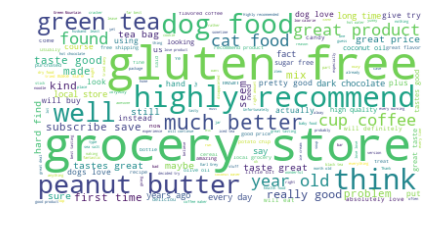

In [51]:
text = [x[0] for x in df.select('Text').collect()]
stopwords = set(STOPWORDS)
stopwords.update(['amazon', 'br', 'gp', 'though', 'although' ,'got', 'used', 'even', 
                  'href', 'either', 'know', 'thought', 'one'])
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(text))
plt.figure(figsize=[7,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Since this is a food review dataset it stands to reason that most of the words are food related and adjectives describing the experience

## Comparing the Models

In [9]:
def build_pipeline(binary):
    if binary:
        countVectors = CountVectorizer(inputCol='filtered', outputCol='features', 
                                       vocabSize=hyperparameters['cv_vocab_size'], 
                                       minDF=hyperparameters['min_support'], binary=True)
        countVectorsSummary = CountVectorizer(inputCol='filteredSummary', 
                                              outputCol='featuresSummary', 
                                              vocabSize=hyperparameters['cv_vocab_size'], 
                                              minDF=hyperparameters['min_support'], binary=True)
        return Pipeline(stages=[countVectors, countVectorsSummary])
    hashingTF = HashingTF(inputCol='filtered', outputCol='rawFeatures', 
                          numFeatures=hyperparameters['tfidf_num_features'])
    idf = IDF(inputCol='rawFeatures', outputCol='features', 
              minDocFreq=hyperparameters['min_support'])
    hashingTFSummary = HashingTF(inputCol='filteredSummary', outputCol='rawFeaturesSummary', 
                                 numFeatures=hyperparameters['tfidf_num_features'])
    idfSummary = IDF(inputCol='rawFeaturesSummary', outputCol='featuresSummary', 
                     minDocFreq=hyperparameters['min_support'])
    return Pipeline(stages=[hashingTF, hashingTFSummary, idf, idfSummary])

def evaluate(predictions, prediction_column='prediction'):
    predictionAndLabels = sc.parallelize([(float(x[0]), float(x[1])) 
                                      for x in predictions.select(prediction_column, 
                                                                  'label').collect()])
    binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
    metrics = MulticlassMetrics(predictionAndLabels)
    print 'Precision = %s' % metrics.precision()
    print 'Recall = %s' % metrics.recall()
    print 'AUC Score = %s' % binary_metrics.areaUnderROC

## Simple Binary Vectors

In [10]:
data = build_pipeline(binary=True).fit(df).transform(df)
data.show()

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Text|             Summary|label|           Tokenized|            filtered|    SummaryTokenized|     filteredSummary|            features|     featuresSummary|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|I have bought sev...|Good Quality Dog ...|  1.0|[i, have, bought,...|[have, bought, se...|[good, quality, d...|[good, quality, d...|(36547,[0,1,2,5,1...|(10977,[1,18,19,5...|
|"Product arrived ...|   Not as Advertised|  0.0|[product, arrived...|[product, arrived...|[not, as, adverti...|   [not, advertised]|(36547,[2,9,10,25...|(10977,[6,572],[1...|
|"This is a confec...|"""Delight"" says...|  1.0|[this, is, a, con...|[confection, that...|[delight, says, i...|[delight

### Classification

We will use AUC ROC to evaluate our models, a popular estimation method for binary classification problems

In [53]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)

#### Logistic Regression

In [12]:
predictions = LogisticRegression(maxIter=hyperparameters['lr_iterations'], 
                                 regParam=hyperparameters['lr_regparam'], 
                                 elasticNetParam=hyperparameters['lr_elastic']).fit(
    trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.842241790381
Recall = 0.842241790381
AUC Score = 0.5


#### Random Forest

In [13]:
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(data)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', 
                               maxCategories=hyperparameters['rf_max_categories']).fit(data)
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', 
                            numTrees=hyperparameters['rf_num_trees'])
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                               labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions, 'predictedLabel')

Precision = 0.842521537337
Recall = 0.842521537337
AUC Score = 0.500886632007


#### Linear SVM

In [14]:
predictions = LinearSVC(maxIter=hyperparameters['svm_maxIter'], 
                        regParam=hyperparameters['svm_reg']).fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.926916107703
Recall = 0.926916107703
AUC Score = 0.807408594376


#### Naive Bayes Bernoulli

In [15]:
predictions = NaiveBayes(smoothing=hyperparameters['nb_smoothing'], 
                         modelType='bernoulli').fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.895965921734
Recall = 0.895965921734
AUC Score = 0.810487912171


#### Naive Bayes

In [16]:
predictions = NaiveBayes(smoothing=hyperparameters['nb_smoothing']).fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.910652636933
Recall = 0.910652636933
AUC Score = 0.839382392726


### Clustering

We used a simple KMeans algorithm to perform the clustering with two clusters - K=2 and K=5, the assumption being that K=2 is similar to binary classification and K=5 is similar to the initial problem we tried to tackle which was to classify the review on a score of 1 through 5.
Same as before we see that the easier problem, i.e. K=2, shows better results than K=5

#### K=2

In [54]:
predictions = KMeans().setK(2).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.239024700385
Recall = 0.239024700385
AUC Score = 0.490664928481


#### K=5

In [18]:
predictions = KMeans().setK(5).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.0794735670916
Recall = 0.0794735670916
AUC Score = 0.471599524404


## TF-IDF Vectors

In [19]:
data = build_pipeline(binary=False).fit(df).transform(df)
data.show()

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Text|             Summary|label|           Tokenized|            filtered|    SummaryTokenized|     filteredSummary|         rawFeatures|  rawFeaturesSummary|            features|     featuresSummary|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|I have bought sev...|Good Quality Dog ...|  1.0|[i, have, bought,...|[have, bought, se...|[good, quality, d...|[good, quality, d...|(50000,[1299,1757...|(50000,[8993,2865...|(50000,[1299,1757...|(50000,[8993,2865...|
|"Product arrived ...|   Not as Advertised|  0.0|[product, arrived...|[product, arrived...|[not, as, adverti...|   [not, adverti

### Classification

We used multiple classfication algorithms - Logistic Regression, Random Forest, SVM and Naive Bayes with the later giving the highest ROC AUC scores

In [29]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)

#### Logistic Regression

In [21]:
predictions = LogisticRegression(maxIter=hyperparameters['lr_iterations'], 
                                 regParam=hyperparameters['lr_regparam'], 
                                 elasticNetParam=hyperparameters['lr_elastic']).fit(
    trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.842241790381
Recall = 0.842241790381
AUC Score = 0.5


#### Random Forest

In [22]:
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(data)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', 
                               maxCategories=hyperparameters['rf_max_categories']).fit(data)
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', 
                            numTrees=hyperparameters['rf_num_trees'])
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                               labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
predictions = pipeline.fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='indexedLabel', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions, 'predictedLabel')

Precision = 0.842521537337
Recall = 0.842521537337
AUC Score = 0.500886632007


#### Linear SVM

In [23]:
predictions = LinearSVC(maxIter=hyperparameters['svm_maxIter'], 
                        regParam=hyperparameters['svm_reg']).fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.923088660711
Recall = 0.923088660711
AUC Score = 0.794753813419


#### Naive Bayes

In [30]:
predictions = NaiveBayes(smoothing=hyperparameters['nb_smoothing']).fit(trainingData).transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction',
                                              metricName='areaUnderROC')
evaluate(predictions)

Precision = 0.883021267127
Recall = 0.883021267127
AUC Score = 0.840599873478


### Clustering

#### K=2

In [52]:
predictions = KMeans().setK(2).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.239024700385
Recall = 0.239024700385
AUC Score = 0.490664928481


#### K=5

In [26]:
predictions = KMeans().setK(5).setSeed(42).fit(trainingData).transform(testData)
evaluate(predictions)

Precision = 0.167517563658
Recall = 0.167517563658
AUC Score = 0.492397573885


## Result Summary

### Classification

The Naive Bayes model with TF-IDF showed the best results overall. The runner-up model, SVM, was actually slightly better with a binary input

### Clustering

When looking at K=2 we see that the results are the same when comparing TF-IDF to regular binary count vectors but on K=5 the TF-IDF proves stronger (though not by a lot) over its binary counterpart